# Bootstrapping

Lucas De Oliveira, Kooha Kwon, Melvin Vellera

In [141]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import t
import random
import matplotlib.pyplot as plt

## Quick Recap

Bootstrapping is a technique of **iterative resampling with replacement** to make inferences about the general population without conducting more experiments.

Say we ran an experiments with the following experimental results:

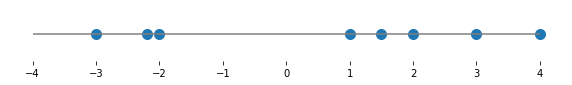

In [142]:
# Experimental sample
exp_sample = [-3, -2.2, -2, 1, 1.5, 2, 3, 4]

# Plot
fig, ax = plt.subplots(figsize = (10, 1))
ax.hlines(y = 0.0, xmax = 4.0, xmin = -4.0, color = 'grey')
ax.scatter(exp_sample, [0]*len(exp_sample), s = 100)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Let's see what bootstrapped samples look like (re-run code cell to see variability of samples)...

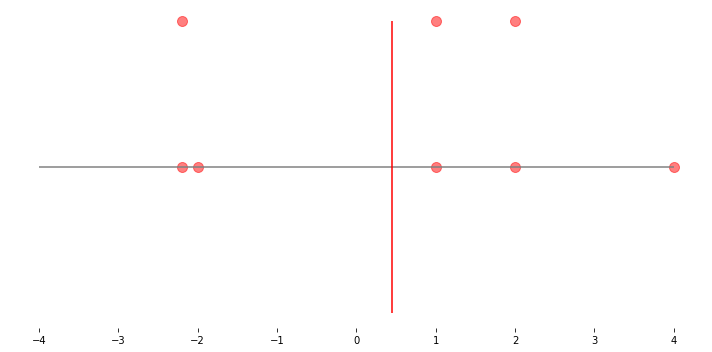

In [143]:
# Get two bootstrapped samples
inds = np.random.randint(0,8,8)
strap = [exp_sample[j] for j in inds]
val_count = Counter(strap)

bootstrap = []
counts = []
for val, count in val_count.items():
    k = 1
    while k <= count:
        bootstrap.append(val)
        counts.append(k)
        k += 1       


# Plot
fig, ax = plt.subplots(figsize = (10, 5))

ax.hlines(y = 1.0, xmax = 4.0, xmin = -4.0, color = 'grey')
ax.scatter(bootstrap, counts, s = 100, color = 'red', alpha = .5)

ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.vlines(x = np.mean(bootstrap), ymin = 0.0, ymax = 2.0, color = 'red')

plt.tight_layout()
plt.show()

Finally, we can analyze the summary statistic(s) for our bootstrapped samples:

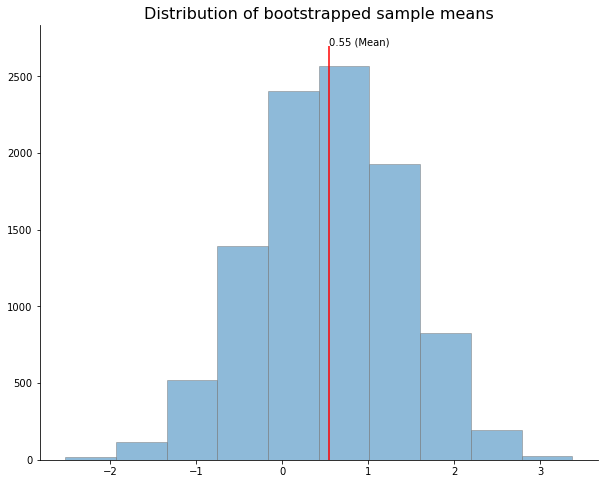

In [144]:
# Bootstrap 10,000 samples
means = []

for i in range(10_000):
    inds = np.random.randint(0,8,8)
    strap = [exp_sample[j] for j in inds]
    means.append(np.mean(strap))

# Plot
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(means, alpha = .5, edgecolor = 'grey')
ax.vlines(x = np.mean(means), ymin = 0, ymax = 2700, color = 'red')
ax.annotate(f'{np.mean(means):.2f} (Mean)', (np.mean(means), 2700))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of bootstrapped sample means', size = 16)

plt.show()

## Example with Real Data

**Description of example/data here** -- for now I have included BodyFatPercentage.csv

1. Take sample size 10 from one of the columns (we'll call the population)
2. Use traditional t-dist for confidence interval (too wide)
3. Bootstrap sample size 10 10,000x
4. Compare to population

In [145]:
# Load data
bfp = pd.read_csv('BodyFatPercentage.csv')
bfp.head()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1,12.6,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,2,6.9,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,3,24.6,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,4,10.9,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,5,27.8,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


### Using sklearn

Instead of bootstrapping manually, we can use scikit-learn's resample() function...

In [146]:
from sklearn.utils import resample
a = [1, 2, 3, 4, 5, 6, 8, 9, 10]
b = resample(a, replace = True, n_samples = len(a), random_state = 1)
b

[6, 10, 6, 1, 1, 2, 9, 8, 3]

### Look at distribution of sample (population)

**We can consider using an entire column to represent the population and select a random sample from the column to play with. Then we can compare to "population" to see how distributions differ.**

### Bootstrap and calculate statistic

###

In [147]:
bf_mean = bfp['BODYFAT'].mean()
pop_n = len(bfp)
print(pop_n)

252


In [148]:
print(f'''Average Body Fat: {bf_mean:.2f}\nNumber of Observations: {pop_n}''')

Average Body Fat: 18.94
Number of Observations: 252


In [149]:
# Lets say that we only have N = 15:
sample_bfp = bfp.loc[random.sample(range(252), 15)]
sample_bfp

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
91,92,18.1,1.0573,44,179.75,69.50,39.2,101.9,93.2,100.6,58.9,39.7,23.1,31.4,28.4,18.8
61,62,28.8,1.0317,56,178.75,68.50,35.6,102.9,94.7,100.8,60.9,38.0,22.1,32.5,29.8,18.3
145,146,14.4,1.0664,24,156.00,70.75,35.7,92.7,81.9,95.3,56.4,36.5,22.0,33.5,28.3,17.3
128,129,20.4,1.0515,40,192.25,73.25,39.8,103.9,93.5,99.5,61.7,39.0,21.8,33.3,29.6,18.1
72,73,9.1,1.0796,56,160.75,73.75,36.4,93.6,82.9,96.3,52.9,37.5,23.1,29.7,27.3,18.2
143,144,9.9,1.0775,23,159.75,72.25,35.5,92.1,77.1,93.9,56.1,36.1,22.7,30.5,27.2,18.2
173,174,16.8,1.0603,36,176.25,71.50,38.7,98.2,90.3,99.9,59.2,37.7,21.5,32.4,28.4,17.8
111,112,27.1,1.0355,43,183.25,70.00,37.1,108.0,105.0,103.0,63.7,40.0,23.6,33.5,27.8,17.4
104,105,24.7,1.0412,43,177.00,69.25,39.6,104.0,98.6,99.5,59.5,36.1,22.0,30.1,27.2,17.7
125,126,17.4,1.0587,46,167.00,67.00,36.6,101.0,89.9,100.0,60.7,36.0,21.9,35.6,30.2,17.6


In [150]:
s = np.std(sample_bfp['BODYFAT'], ddof = 1)
samp_n = len(sample_bfp)
sample_mean = sample_bfp['BODYFAT'].mean()
stat_ci = [sample_mean - t.ppf(1 - 0.05/2, samp_n-1)* (s / np.sqrt(n)), sample_mean + t.ppf(1 - 0.05/2, samp_n-1)* (s / np.sqrt(samp_n))]
print(f'''Population Mean: {bf_mean:.2f}\nSample Mean: {sample_mean:.2f}\nStatistical Confidence Interval: {[f'{e:.2f}' for e in stat_ci]}\nInterval Range: {stat_ci[1] - stat_ci[0]:.2f}''')

Population Mean: 18.94
Sample Mean: 17.11
Statistical Confidence Interval: ['12.91', '21.30']
Interval Range: 8.39


In [151]:
resample_means = []
for i in range(10_000):
    inds = np.random.randint(0, samp_n-1, samp_n-1)
    mean = sample_bfp['BODYFAT'].iloc[inds].mean()
    resample_means.append(mean)
    
boot_mean = np.mean(resample_means)
boot_ci = [np.quantile(resample_means, 0.025), np.quantile(resample_means, 0.975)]

# print(f'''Statistical Confidence Interval: {[f'{e:.2f}' for e in stat_ci]}''')
print(f'''Bootstrap Confidence Interval: {[f'{e:.2f}' for e in boot_ci]}\nInterval Range: {boot_ci[1]-boot_ci[0]:.2f}''')

Bootstrap Confidence Interval: ['13.62', '21.33']
Interval Range: 7.71


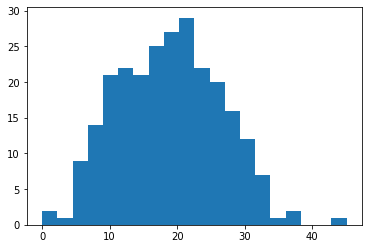

In [152]:
plt.hist(bfp['BODYFAT'],bins=20)
plt.show()

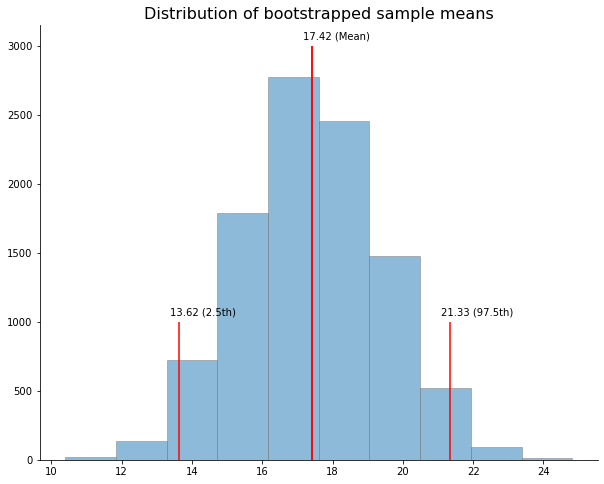

In [153]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(resample_means, alpha = .5, edgecolor = 'grey')
ax.vlines(x = boot_mean, ymin = 0, ymax = 3000, color = 'red')
ax.vlines(x = boot_ci[0], ymin = 0, ymax = 1000, color = 'red')
ax.vlines(x = boot_ci[1], ymin = 0, ymax = 1000, color = 'red')
ax.vlines(x = boot_mean, ymin = 0, ymax = 3000, color = 'red')

ax.annotate(f'{boot_mean:.2f} (Mean)', (boot_mean-0.25, 3050))
ax.annotate(f'{boot_ci[0]:.2f} (2.5th)', (boot_ci[0]-0.25, 1050))
ax.annotate(f'{boot_ci[1]:.2f} (97.5th)', (boot_ci[1]-0.25, 1050))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of bootstrapped sample means', size = 16)

plt.show()

#### Example with Rsquared, a statistic that might not have a well known statistical calculation 

In [154]:
# Bootstrapping for Rsquared
import statsmodels.formula.api as smf
model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE', data = bfp).fit()

# Model for a sample of the data
samp_n = 30
sample_bfp = bfp.loc[random.sample(range(pop_n), samp_n)]
sample_model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE', data = sample_bfp).fit()

print(f'Population Rsquared_adj: {model.rsquared_adj:.2f}\nSample Rsquared_adj: {sample_model.rsquared_adj:.2f}')

Population Rsquared_adj: 0.71
Sample Rsquared_adj: 0.68


In [155]:
adj_rsquareds = []

for i in range(1_000):
    inds = np.random.randint(0, samp_n-1, samp_n-1)
    model = smf.ols('BODYFAT ~ ABDOMEN + WRIST + ANKLE + AGE', data = sample_bfp.iloc[inds]).fit()
    rsq_adj = model.rsquared_adj
    adj_rsquareds.append(rsq_adj)
    
boot_rsq_adj_mean = np.mean(adj_rsquareds)
boot_rsq_adj_ci = [np.quantile(adj_rsquareds, 0.025), np.quantile(adj_rsquareds, 0.975)]
print(f'''Bootstrap Confidence Interval (Adjusted Rsquared): {[f'{e:.2f}' for e in boot_rsq_adj_ci]}''')

Bootstrap Confidence Interval (Adjusted Rsquared): ['0.44', '0.86']


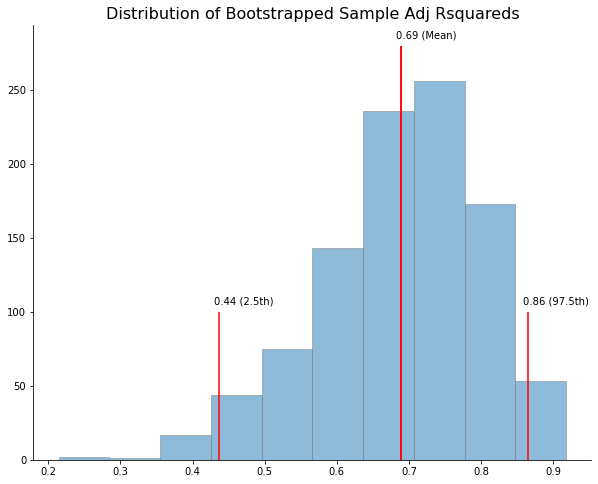

In [156]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(adj_rsquareds, alpha = .5, edgecolor = 'grey')
ax.vlines(x = boot_rsq_adj_mean, ymin = 0, ymax = 280, color = 'red')
ax.vlines(x = boot_rsq_adj_ci[0], ymin = 0, ymax = 100, color = 'red')
ax.vlines(x = boot_rsq_adj_ci[1], ymin = 0, ymax = 100, color = 'red')
ax.vlines(x = boot_rsq_adj_mean, ymin = 0, ymax = 280, color = 'red')

ax.annotate(f'{boot_rsq_adj_mean:.2f} (Mean)', (boot_rsq_adj_mean-0.007, 285))
ax.annotate(f'{boot_rsq_adj_ci[0]:.2f} (2.5th)', (boot_rsq_adj_ci[0]-0.007, 105))
ax.annotate(f'{boot_rsq_adj_ci[1]:.2f} (97.5th)', (boot_rsq_adj_ci[1]-0.007, 105))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Distribution of Bootstrapped Sample Adj Rsquareds', size = 16)

plt.show()